In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import pyhf
import pyhf.readxml
from pyhf.contrib.viz import brazil

import base64
from IPython.display import display, HTML
from ipywidgets import interact, fixed

# Binned HEP Statistical Analysis in Python

## HistFactory

HistFactory is a popular framework to analyze binned event data and commonly used in High Energy Physics. At its core it is a template for building a statistical model from individual binned distribution ('Histograms') and variations on them ('Systematics') that represent auxiliary measurements (for example an energy scale of the detector which affects the shape of a distribution)

## pyhf

`pyhf` is a work-in-progress standalone implementation of the HistFactory p.d.f. template and an implementation of the test statistics and asymptotic formulae described in the paper by Cowan, Cranmer, Gross, Vitells: *Asymptotic formulae for likelihood-based tests of new physics* [[arXiv:1007.1727](https://arxiv.org/abs/1007.1727)].

Models can be defined using JSON specification, but existing models based on the XML + ROOT file scheme are readable as well.

## The Demo

The input data for the statistical analysis was built generated using the containerized workflow engine [yadage](https://github.com/yadage/yadage) (see demo from KubeCon 2018 [[youtube](https://youtu.be/2PRGUOxL36M)]). Similarly to Binder this utilizes modern container technology for reproducible science. Below you see the execution graph leading up to the model input data at the bottom.


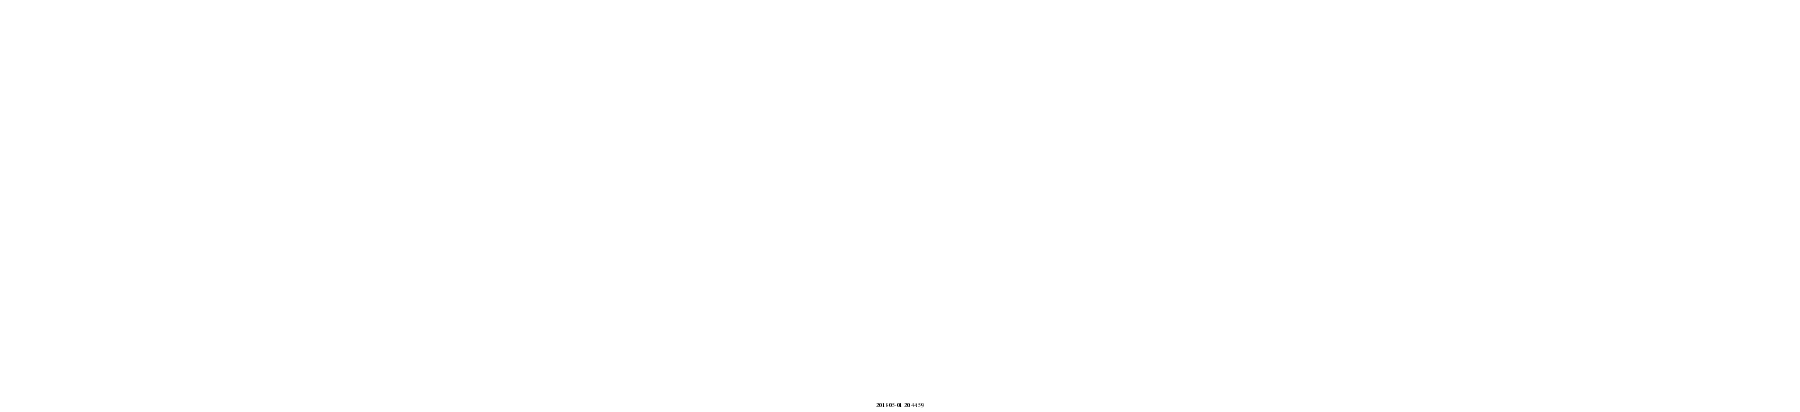

In [2]:
anim = base64.b64encode(open('workflow.gif', 'rb').read()).decode('ascii')
HTML(f'<img src="data:image/gif;base64,{anim}">')

## Read in the Model from XML and ROOT

The ROOT files are read using scikit-hep's [uproot](https://github.com/scikit-hep/uproot) module.

In [3]:
spec = pyhf.readxml.parse('meas.xml', Path.cwd())
workspace = pyhf.Workspace(spec)

From the `meas.xml` spec, we construct a probability density function (p.d.f). As the model includes systematics, it will be a simultaneous joint p.d.f. of the main model (poisson) and constraint model. The latter is defined by the implied "auxiliary measurements".

In [4]:
pdf = workspace.model(measurement_name='meas')
data = workspace.data(pdf)
# what is the measurement?
workspace.get_measurement(measurement_name='meas')

{'name': 'meas',
 'config': {'poi': 'SigXsecOverSM',
  'parameters': [{'name': 'lumi',
    'auxdata': [1.0],
    'bounds': [[0.5, 1.5]],
    'inits': [1.0],
    'sigmas': [0.1]},
   {'name': 'SigXsecOverSM',
    'bounds': [[0.0, 3.0]],
    'inits': [1.0],
    'fixed': False}]}}

The p.d.f is build from one data-drived "qcd" (or multijet) estimate and two Monte Carlo-based background samples and is parametrized by five parameters: One parameter of interest `SigXsecOverSM` and four *nuisance parameters* that affect the shape of the two Monte Carlo background estimates (both weight-only and shape systematics)

In [5]:
print(f'Samples:\n {pdf.config.samples}')
print(f'Parameters:\n {pdf.config.parameters}')

Samples:
 ['mc1', 'mc2', 'qcd', 'signal']
Parameters:
 ['SigXsecOverSM', 'lumi', 'mc1_shape_conv', 'mc1_weight_var1', 'mc2_shape_conv', 'mc2_weight_var1']


In [6]:
par_name_dict = {k: v["slice"].start for k, v in pdf.config.par_map.items()}
all_par_settings = {
    n[0]: tuple(m)
    for n, m in zip(
        sorted(reversed(list(par_name_dict.items())), key=lambda x: x[1]),
        pdf.config.suggested_bounds(),
    )
}
default_par_settings = {n[0]: sum(tuple(m)) / 2.0 for n, m in all_par_settings.items()}

In [7]:
def get_mc_counts(pars):
    deltas, factors = pdf.modifications(pars)
    allsum = pyhf.tensorlib.concatenate(
        deltas + [pyhf.tensorlib.astensor(pdf.nominal_rates)]
    )
    nom_plus_delta = pyhf.tensorlib.sum(allsum, axis=0)
    nom_plus_delta = pyhf.tensorlib.reshape(
        nom_plus_delta, (1,) + pyhf.tensorlib.shape(nom_plus_delta)
    )
    allfac = pyhf.tensorlib.concatenate(factors + [nom_plus_delta])
    return pyhf.tensorlib.product(allfac, axis=0)


animate_plot_pieces = None


def init_plot(fig, ax, par_settings):
    global animate_plot_pieces

    nbins = sum(list(pdf.config.channel_nbins.values()))
    x = np.arange(nbins)
    data = np.zeros(nbins)
    items = []
    for i in [3, 2, 1, 0]:
        items.append(ax.bar(x, data, 1, alpha=1.0))
    animate_plot_pieces = (
        items,
        ax.scatter(
            x, workspace.data(pdf, include_auxdata=False), c="k", alpha=1.0, zorder=99
        ),
    )


def animate(ax=None, fig=None, **par_settings):
    global animate_plot_pieces
    items, obs = animate_plot_pieces
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    for k, v in par_settings.items():
        pars[par_name_dict[k]] = v

    mc_counts = get_mc_counts(pars)
    rectangle_collection = zip(*map(lambda x: x.patches, items))

    for rectangles, binvalues in zip(rectangle_collection, mc_counts[:, 0].T):
        offset = 0
        for sample_index in [3, 2, 1, 0]:
            rect = rectangles[sample_index]
            binvalue = binvalues[sample_index]
            rect.set_y(offset)
            rect.set_height(binvalue)
            offset += rect.get_height()

    fig.canvas.draw()


def plot(ax=None, order=[3, 2, 1, 0], **par_settings):
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    for k, v in par_settings.items():
        pars[par_name_dict[k]] = v

    mc_counts = get_mc_counts(pars)
    bottom = None
    # nb: bar_data[0] because evaluating only one parset
    for i, sample_index in enumerate(order):
        data = mc_counts[sample_index][0]
        x = np.arange(len(data))
        ax.bar(x, data, 1, bottom=bottom, alpha=1.0)
        bottom = data if i == 0 else bottom + data
    ax.scatter(
        x, workspace.data(pdf, include_auxdata=False), c="k", alpha=1.0, zorder=99
    )

## Interactive Exploration of a HistFactory Model

One advantage of a pure-python implementation of Histfactory is the ability to explore the pdf interactively within the setting of a notebook. Try moving the sliders and oberserve the effect on the samples. For example changing the parameter of interest `SigXsecOverSM` (or µ) controls the overall normalization of the (BSM) signal sample (µ=0 for background-only and µ=1 for the nominal signal-plus-background hypothesis)

<IPython.core.display.Javascript object>


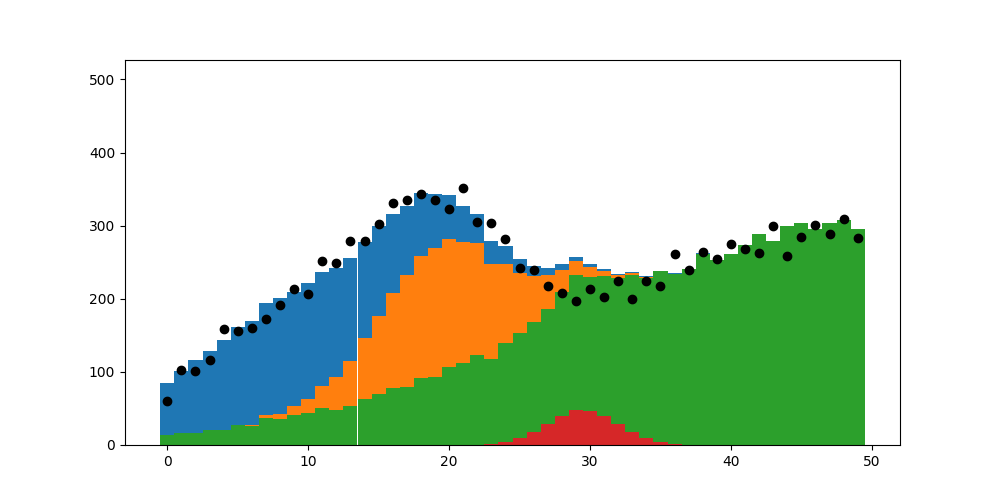

interactive(children=(FloatSlider(value=1.0, description='lumi', max=1.5, min=0.5), FloatSlider(value=1.5, des…

In [8]:
%matplotlib widget
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ax.set_ylim(0, 1.5 * np.max(workspace.data(pdf, include_auxdata=False)))

init_plot(fig, ax, default_par_settings)
interact(animate, fig=fixed(fig), ax=fixed(ax), **all_par_settings);

In [9]:
nominal = pdf.config.suggested_init()
background_only = pdf.config.suggested_init()
background_only[pdf.config.poi_index] = 0.0
best_fit = pyhf.infer.mle.fit(data, pdf)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:334: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


## Fitting

We can now fit the statistical model to the observed data. The best fit of the signal strength is close to the background-only hypothesis.

<IPython.core.display.Javascript object>


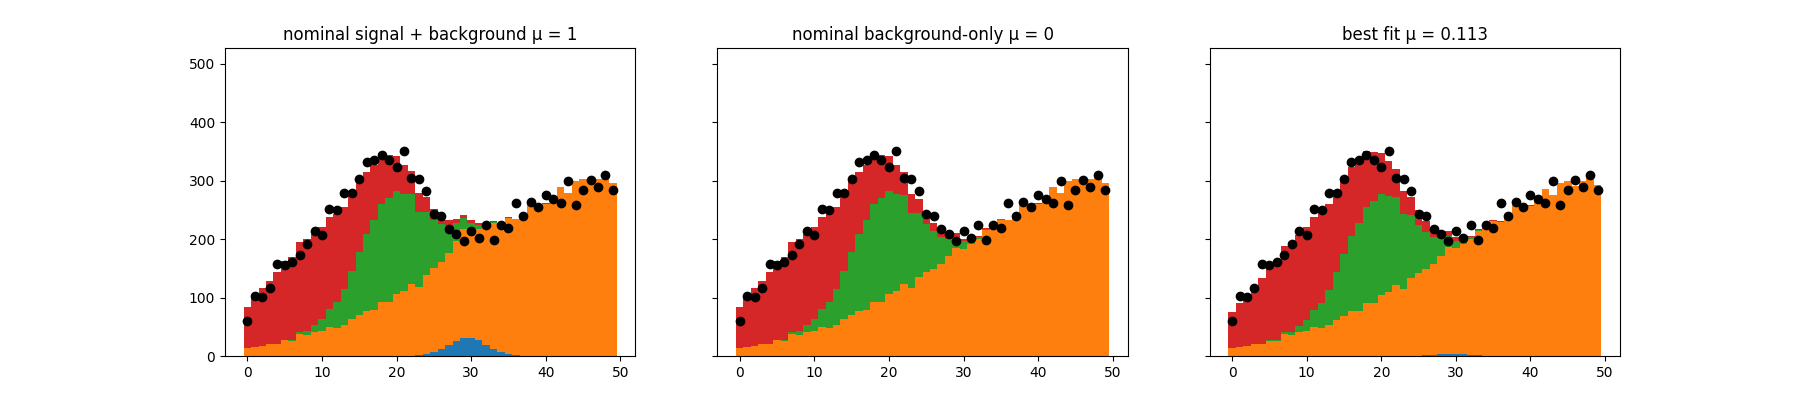

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True)
fig.set_size_inches(18, 4)
ax1.set_ylim(0, 1.5 * np.max(workspace.data(pdf, include_auxdata=False)))
ax1.set_title('nominal signal + background µ = 1')
plot(ax=ax1, **{k: nominal[v] for k, v in par_name_dict.items()})

ax2.set_title('nominal background-only µ = 0')
plot(ax=ax2, **{k: background_only[v] for k, v in par_name_dict.items()})

ax3.set_title(f'best fit µ = {best_fit[pdf.config.poi_index]:.3g}')
plot(ax=ax3, **{k: best_fit[v] for k, v in par_name_dict.items()});

## Interval Estimation (Computing Upper Limits on µ)

A common task in the statistical evaluation of High Energy Physics data analyses is the estimation of confidence intervals of parameters of interest. The general strategy is to perform a series of hypothesis tests and then *invert* the tests in order to obtain an interval with the correct coverage properties.

A common figure of merit is a modified p-value, CLs. Here we compute an upper limit based on a series of CLs tests.

In [11]:
mu_tests = np.linspace(0, 1, 16)
(
    obs_limit,
    exp_limits,
    (poi_tests, tests),
) = pyhf.infer.intervals.upper_limits.upper_limit(
    data, pdf, mu_tests, level=0.05, return_results=True
)

<IPython.core.display.Javascript object>


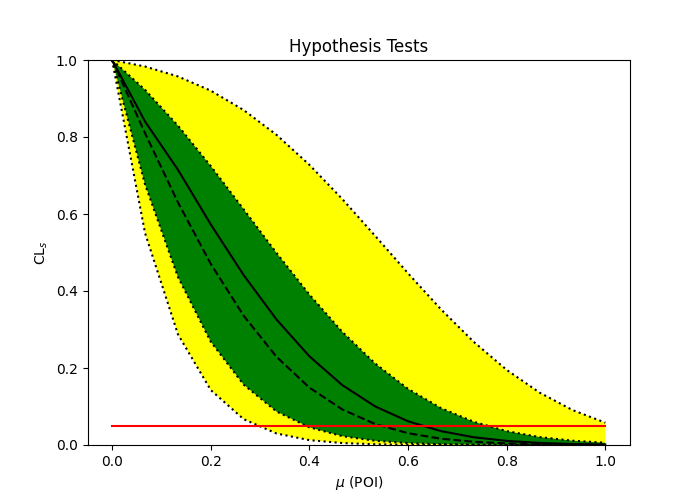

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)

ax.set_title("Hypothesis Tests")
artists = brazil.plot_results(mu_tests, tests, test_size=0.05, ax=ax)

In [13]:
print(f"Observed upper limit: {obs_limit:.3f}\n")
for i, n_sigma in enumerate(np.arange(-2, 3)):
    print(
        "Expected Limit{}: {:.3f}".format(
            "" if n_sigma == 0 else f"({n_sigma} σ)", exp_limits[i]
        )
    )

Observed upper limit: 0.630

Expected Limit(-2 σ): 0.297
Expected Limit(-1 σ): 0.393
Expected Limit: 0.546
Expected Limit(1 σ): 0.762
Expected Limit(2 σ): 1.000
